# Homework 05: Decision Tree Regression
## Kerem Aksoy

Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

##Importing DataSet as traning and test sets

In [ ]:
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",")

#First row is the titles for coloumns, so we need to be careful about it
X_train = data_set[1:151,0]
Y_train = data_set[1:151,1]

X_test = data_set[151:,0]
Y_test = data_set[151:,1]

#150 for training
#122 for test
N_train = len(Y_train)
N_test = len(Y_test)

N = len(Y_test) + len(Y_train) #Total Number of data points
D = 1 #Number of features

# A Note: In this hw, we have only one feature, so we can code according to one feature. However, I want to code it in a more general way.
# So, if we use multifeatures data set, we can change some parameters like D,and directly use this code

## Initialization

In [ ]:
# Since we implement prepruning that if a node have smaller than P data points, stop splitting
P = 25 
# create necessary data structures
node_indices = {} # Key --> Node , Value--> the indices of the data points which belongs to the node
is_terminal = {} # Key --> Node, value --> boolean To know whether a node is terminal or not
need_split = {} # Key --> Node, value--> boolean To know whether a split needs a split or not
node_splits = {} # The values(boundries) of the splits for each node

# put all training instances into the root node initially
node_indices[1] = np.array(range(N_train))
is_terminal[1] = False
need_split[1] = True

## Traning the decision tree

In [ ]:
# learning algorithm
iteration=0
while True:
    iteration+=1
    # find nodes that need splitting
    # In the first iteration, it only returns root node
    split_nodes = [key for key, value in need_split.items() if value == True] # If a node needs a split it returns its keys
    # check whether we reach all terminal nodes
    if len(split_nodes) == 0:
        break
    # find best split positions for all nodes
    for split_node in split_nodes:
      data_indices = node_indices[split_node]
      need_split[split_node] = False #Since we are splitting the node, it does not need split anymore
       #It does not matter whether we will split t or not, since if it needs one it will be splitted
      if len(data_indices) <= P: #If it has number of data points smaller than P (pre pruning)
          is_terminal[split_node] = True
      else:
          is_terminal[split_node] = False

          min_errors = np.repeat(0.0, D) 
          best_splits = np.repeat(0.0, D)
          for d in range(D): #Since D is 1, it enters this loop only ones.
              unique_values = np.sort(np.unique(X_train[data_indices])) 
              #Taking the middle value of each interval between possible values of the feature
              split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
              split_errors = np.repeat(0.0, len(split_positions)) # This will hold each score of the split
              for s in range(len(split_positions)):
                  left_indices = data_indices[X_train[data_indices] > split_positions[s]] #True case
                  right_indices = data_indices[X_train[data_indices] <= split_positions[s]] #False case
                  gm_L = np.mean(Y_train[left_indices])
                  gm_R = np.mean(Y_train[right_indices])
                  ##############################
                  # Ask why this does not work.(Why there is a overfitting?)
                  #split_errors[s] = (1/len(left_indices))*np.sum((Y_train[left_indices]-gm_L)**2) + (1/len(right_indices))*np.sum((Y_train[right_indices]-gm_R)**2)
                  ###############################
                  split_errors[s] = (1/len(data_indices))*(np.sum((Y_train[left_indices]-gm_L)**2) + np.sum((Y_train[right_indices]-gm_R)**2))
              min_errors[d] = np.min(split_errors)
              best_splits[d] = split_positions[np.argmin(split_errors)]
            # decide where to split on which feature
          split_d = np.argmin(min_errors)
          node_splits[split_node] = best_splits[split_d]
          # create left node using the selected split(True branch)
          left_indices = data_indices[X_train[data_indices] > best_splits[split_d]]
          node_indices[2 * split_node] = left_indices
          is_terminal[2 * split_node] = False
          need_split[2 * split_node] = True
      
          # create right node using the selected split(False Branch)
          right_indices = data_indices[X_train[data_indices] <= best_splits[split_d]]
          node_indices[2 * split_node + 1] = right_indices
          is_terminal[2 * split_node + 1] = False
          need_split[2 * split_node + 1] = True

## Rule Extraction 

In [ ]:
terminal_nodes = [key for key, value in is_terminal.items() if value == True]
print(len(terminal_nodes))
for terminal_node in terminal_nodes:
    index = terminal_node
    rules = np.array([])
    while index > 1:
        parent = np.floor(index / 2)
        if index % 2 == 0:
            # if node is left child of its parent
            rules = np.append(rules, "x> {:.2f}".format(node_splits[parent]))
        else:
            # if node is right child of its parent
            rules = np.append(rules, "x <= {:.2f}".format(node_splits[parent]))
        index = parent
    rules = np.flip(rules)
    print("{} => {}".format(rules, len(node_indices[terminal_node])))

15
['x <= 2.98' 'x> 2.18'] => 12
['x> 2.98' 'x> 4.31' 'x> 5.08'] => 1
['x> 2.98' 'x <= 4.31' 'x <= 3.41'] => 4
['x <= 2.98' 'x <= 2.18' 'x <= 1.72'] => 3
['x> 2.98' 'x> 4.31' 'x <= 5.08' 'x <= 4.41'] => 10
['x> 2.98' 'x <= 4.31' 'x> 3.41' 'x <= 3.70'] => 6
['x <= 2.98' 'x <= 2.18' 'x> 1.72' 'x> 1.96'] => 15
['x> 2.98' 'x> 4.31' 'x <= 5.08' 'x> 4.41' 'x <= 4.58'] => 16
['x> 2.98' 'x <= 4.31' 'x> 3.41' 'x> 3.70' 'x> 3.84'] => 22
['x> 2.98' 'x <= 4.31' 'x> 3.41' 'x> 3.70' 'x <= 3.84'] => 6
['x <= 2.98' 'x <= 2.18' 'x> 1.72' 'x <= 1.96' 'x> 1.85'] => 9
['x <= 2.98' 'x <= 2.18' 'x> 1.72' 'x <= 1.96' 'x <= 1.85'] => 17
['x> 2.98' 'x> 4.31' 'x <= 5.08' 'x> 4.41' 'x> 4.58' 'x> 5.00'] => 1
['x> 2.98' 'x> 4.31' 'x <= 5.08' 'x> 4.41' 'x> 4.58' 'x <= 5.00' 'x> 4.84'] => 6
['x> 2.98' 'x> 4.31' 'x <= 5.08' 'x> 4.41' 'x> 4.58' 'x <= 5.00'
 'x <= 4.84'] => 22


## Finding smallest intervals for each leaf node(terminals)

In [ ]:
terminal_nodes = [key for key, value in is_terminal.items() if value == True]
intervals = {} #Key is termnal node's keys, values are the smallest(narrowest) interval of them
for terminal_node in terminal_nodes:
    index = terminal_node
    anInterval = np.array([np.min(X_train),np.max(X_train)]) #Setting initial boundries (min --> minimum of the set), (max --> maximum of the data set)
    while index > 1:
        parent = np.floor(index / 2)
        if index % 2 == 0:  # if node is left child of its parent
            if node_splits[parent] > anInterval[0]: # We need to narrow the interval by increasing lower bound
              anInterval[0] = node_splits[parent] #Inner bound
        else: # if node is right child of its parent
            if node_splits[parent] < anInterval[1]: ## We need to narrow the interval by lowering upper bound
              anInterval[1] = node_splits[parent] #upper bound
        index = parent # Since we need to achive all of the rules of the path, we need to go to the parent
    intervals[terminal_node]= anInterval # Adding the paths' rule(narrow node, combination of all rules) to the dictionary


Taking Right Boundries and Creating Predictions Dictionary (This is done for drawing purposes)

In [ ]:
predictions = {} #key is the node index(name or key) --> values are the predictions(this will can be used while calculating for new data points)
# Here, there will be only the keys of leaf nodes and values
vertical_helper = {} #This will hold right bounds of intervals of the nodes. This is only for drawing purposes
rightBound= [] # This holds keys of the vertical helper (right bound of the intervals) as list (for drawing purposes)
for key1 in terminal_nodes:
    predictions[key1] = np.mean(Y_train[node_indices[key1]]) #Calculating the prediction
    vertical_helper[intervals[key1][1]] = predictions[key1] #Adding its right bound to list
    rightBound.append(intervals[key1][1]) 

rightBound = np.unique(np.array(rightBound)) # Removing repeating values
np.sort(rightBound) # Sorting it.
## We need to sort this array since we will plot the vertical lines as peaks, so the second y value need to be the next one


array([1.7165, 1.85  , 1.9585, 2.1835, 2.975 , 3.4085, 3.7   , 3.8415,
       4.3085, 4.4085, 4.5835, 4.8415, 5.    , 5.0835, 5.1   ])

## Plotting Traning Set, Test Set, Decision Tree Regression Algorithm Fit 

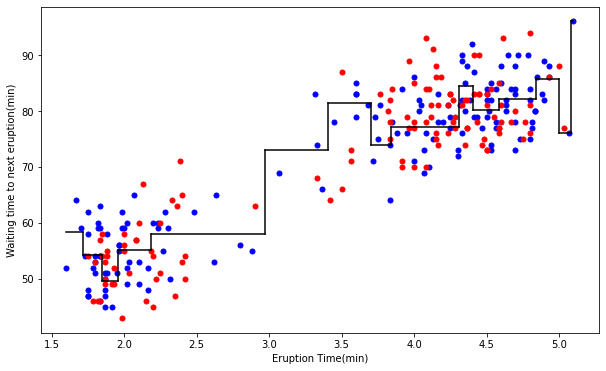

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(X_train,Y_train,"b.",markersize=10) #Plotting training set
plt.plot(X_test,Y_test,"r.",markersize=10) #Plotting test set
terminal_nodes = [key for key, value in is_terminal.items() if value == True]

for key1 in terminal_nodes: #Horizantal
    plt.plot([intervals[key1][0], intervals[key1][1]], [predictions[key1], predictions[key1]], "k-")

for i in range(len(rightBound)-1): # Plotting vertical lines
  currB = rightBound[i];
  peakB = rightBound[i+1];
  plt.plot([currB,currB], [vertical_helper[currB], vertical_helper[peakB]], "k-")

plt.ylabel("Waiting time to next eruption(min)")
plt.xlabel("Eruption Time(min)")
plt.show()


Calculating RMSE FOR TRAINING AND TEST SET

In [ ]:
rmse_train = 0
rmse_test = 0 

for i in range(N_train): #For every data in the traning set
  for key in intervals.keys(): # For a key of each interval
    if( X_train[i] > intervals[key][0] and X_train[i] <= intervals[key][1]): # Find a interval where x value inside it
      rmse_train += (Y_train[i] - predictions[key])**2 # add (real value - prediction)**2  to rmse 
      break
rmse_train = math.sqrt(rmse_train/N_train) #Taking square root of squared difference/N

for i in range(N_test):
  for key in intervals.keys():
    if( X_test[i] > intervals[key][0] and X_test[i] <= intervals[key][1]): # It means it found an fitted interval
      rmse_test += (Y_test[i] - predictions[key])**2 # # add (real value - prediction)**2  to rmse
      break
rmse_test = math.sqrt(rmse_test/N_test) #Taking square root of rmse/N

In [ ]:
print("RMSE on training set is {} when P is {}".format(rmse_train,P))
print("RMSE on test set is {} when P is {}".format(rmse_test,P))

RMSE on training set is 4.511675842160384 when P is 25
RMSE on test set is 6.454083413352087 when P is 25


Learn decision trees for each P (5,10,15,20,25,30,35,40,45,50)

In [ ]:
# This code has the same implementation of the three when P is 25. I use the same code in a for loop, and calculate RMSE for each P
# and store them array(below).
rmse_arr1 = [0,0,0,0,0,0,0,0,0,0]
rmse_arr2 = [0,0,0,0,0,0,0,0,0,0]
for p in range(1,11):
  P=p*5
  node_indices = {} # Key --> Node , Value--> the indices of the data points which belongs to the node
  is_terminal = {} # Key --> Node, value --> boolean To know whether a node is terminal or not
  need_split = {} # Key --> Node, value--> boolean To know whether a split needs a split or not
  node_splits = {} # The values(boundries) of the splits for each node
  node_indices[1] = np.array(range(N_train))
  is_terminal[1] = False
  need_split[1] = True
  # learning algorithm
  iteration=0
  while True:
      iteration+=1
      # find nodes that need splitting
      # In the first iteration, it only returns root node
      split_nodes = [key for key, value in need_split.items() if value == True] # If a node needs a split it returns its keys
      # check whether we reach all terminal nodes
      if len(split_nodes) == 0:
          break
      # find best split positions for all nodes
      for split_node in split_nodes:
        data_indices = node_indices[split_node]
        need_split[split_node] = False #Since we are splitting the node, it does not need split anymore
        #It does not matter whether we will split t or not, since if it needs one it will be splitted
        if len(data_indices) <= P: #If it has number of data points smaller than P (pre pruning)
            is_terminal[split_node] = True
        else:
            is_terminal[split_node] = False

            min_errors = np.repeat(0.0, D) 
            best_splits = np.repeat(0.0, D)
            for d in range(D): #Since D is 1, it enters this loop only ones.
                unique_values = np.sort(np.unique(X_train[data_indices])) 
                #Taking the middle value of each interval between possible values of the feature
                split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
                split_errors = np.repeat(0.0, len(split_positions)) # This will hold each score of the split
                for s in range(len(split_positions)):
                    left_indices = data_indices[X_train[data_indices] > split_positions[s]] #True case
                    right_indices = data_indices[X_train[data_indices] <= split_positions[s]] #False case
                    gm_L = np.mean(Y_train[left_indices])
                    gm_R = np.mean(Y_train[right_indices])
                    ##############################
                    # Ask why this does not work.(Why there is a overfitting?)
                    #split_errors[s] = (1/len(left_indices))*np.sum((Y_train[left_indices]-gm_L)**2) + (1/len(right_indices))*np.sum((Y_train[right_indices]-gm_R)**2)
                    ###############################
                    split_errors[s] = (1/len(data_indices))*(np.sum((Y_train[left_indices]-gm_L)**2) + np.sum((Y_train[right_indices]-gm_R)**2))
                min_errors[d] = np.min(split_errors)
                best_splits[d] = split_positions[np.argmin(split_errors)]
              # decide where to split on which feature
            split_d = np.argmin(min_errors)
            node_splits[split_node] = best_splits[split_d]
            # create left node using the selected split(True branch)
            left_indices = data_indices[X_train[data_indices] > best_splits[split_d]]
            node_indices[2 * split_node] = left_indices
            is_terminal[2 * split_node] = False
            need_split[2 * split_node] = True
        
            # create right node using the selected split(False Branch)
            right_indices = data_indices[X_train[data_indices] <= best_splits[split_d]]
            node_indices[2 * split_node + 1] = right_indices
            is_terminal[2 * split_node + 1] = False
            need_split[2 * split_node + 1] = True

  terminal_nodes = [key for key, value in is_terminal.items() if value == True]
  intervals = {} #Key is termnal node's keys, values are the smallest(narrowest) interval of them
  for terminal_node in terminal_nodes:
      index = terminal_node
      anInterval = np.array([np.min(X_train),np.max(X_train)]) #Setting initial boundries (min --> minimum of the set), (max --> maximum of the data set)
      while index > 1:
          parent = np.floor(index / 2)
          if index % 2 == 0:  # if node is left child of its parent
              if node_splits[parent] > anInterval[0]: # We need to narrow the interval by increasing lower bound
                anInterval[0] = node_splits[parent] #Inner bound
          else: # if node is right child of its parent
              if node_splits[parent] < anInterval[1]: ## We need to narrow the interval by lowering upper bound
                anInterval[1] = node_splits[parent] #upper bound
          index = parent # Since we need to achive all of the rules of the path, we need to go to the parent
      intervals[terminal_node]= anInterval # Adding the paths' rule(narrow node, combination of all rules) to the dictionary
  
  
  predictions = {} #key is the node index(name or key) --> values are the predictions(this will can be used while calculating for new data points)
  # Here, there will be only the keys of leaf nodes and values
  vertical_helper = {} #This will hold right bounds of intervals of the nodes. This is only for drawing purposes
  rightBound= [] # This holds keys of the vertical helper (right bound of the intervals) as list (for drawing purposes)
  for key1 in terminal_nodes:
      predictions[key1] = np.mean(Y_train[node_indices[key1]]) #Calculating the prediction
      vertical_helper[intervals[key1][1]] = predictions[key1] #Adding its right bound to list
      rightBound.append(intervals[key1][1]) 

  rightBound = np.unique(np.array(rightBound)) # Removing repeating values
  np.sort(rightBound) # Sorting it.
  ## We need to sort this array since we will plot the vertical lines as peaks, so the second y value need to be the next one


  for i in range(N_train): #For every data in the traning set
    for key in intervals.keys(): # For a key of each interval
      if( X_train[i] > intervals[key][0] and X_train[i] <= intervals[key][1]): # Find a interval where x value inside it
        rmse_train += (Y_train[i] - predictions[key])**2 # add (real value - prediction)**2  to rmse 
        break
  rmse_train = math.sqrt(rmse_train/N_train) #Taking square root of squared difference/N

  for i in range(N_test):
    for key in intervals.keys():
      if( X_test[i] > intervals[key][0] and X_test[i] <= intervals[key][1]): # It means it found an fitted interval
        rmse_test += (Y_test[i] - predictions[key])**2 # # add (real value - prediction)**2  to rmse
        break
  rmse_test = math.sqrt(rmse_test/N_test) #Taking square root of rmse/N

  rmse_arr1[p-1] = rmse_train
  rmse_arr2[p-1] = rmse_test


Plotting RMSE FOR P=5,10,15,20,25,30,35,40,45,50

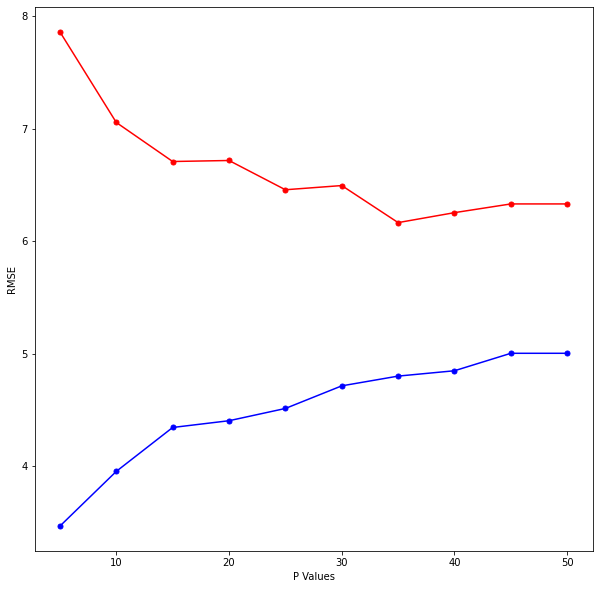

In [ ]:
plt.figure(figsize = (10, 10))
x_values = range(5,51,5)
plt.plot(x_values,rmse_arr1,"b-",markersize=10) #Plotting training set
plt.plot(x_values,rmse_arr2,"r-",markersize=10) #Plotting training set
plt.plot(x_values,rmse_arr1,"b.",markersize=10) #Plotting training set
plt.plot(x_values,rmse_arr2,"r.",markersize=10) #Plotting training set
plt.xlabel("P Values")
plt.ylabel("RMSE")
plt.show()